## Классификация игроков по командам
Задача состоит в том, чтобы на каждом видео классифицировать игроков по двум командам. Особенность этой задачи заключается в том, что команд много, все команды имеют различную экипировку, которая может меняться от игры к игре, и при этом нет соответствующей разметки. Разметку шлемов можно найти в `train_labels.csv`.


Загрузим библиотеки

In [ ]:
import os
import torch
import cv2
import subprocess
import numpy as np
import pandas as pd
from torch import nn
from tqdm import tqdm
import albumentations as A
from sklearn.cluster import KMeans
from google.colab.patches import cv2_imshow
from IPython.core.display import Video
from torchvision.models import resnet18
import torchvision.models as tm
from sklearn.metrics import accuracy_score
from sklearn.cluster import AgglomerativeClustering
import warnings
import time
warnings.filterwarnings("ignore")

Считаем данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root = "/content/drive/MyDrive/ColabNotebooks/nfl-health-and-safety-helmet-assignment/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bboxes = pd.read_csv(root + "train_labels.csv")
bboxes.head()

,video_frame,gameKey,playID,view,video,frame,label,left,width,top,height,impactType,isDefinitiveImpact,isSidelinePlayer
0,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H90,245,21,327,29,None,False,False
1,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V79,310,21,345,12,None,False,False
2,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H97,410,21,323,29,None,False,False
3,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,None,False,False
4,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H50,518,21,212,28,None,False,False


Подготовим фреймы из 10 первых видео

In [ ]:
def make_frame(video_name, frame_dir, img_ext='jpg'):
    ''' Функция, чтобы выделять фреймы для видео '''
    image_name = video_name[:-4]
    os.makedirs(frame_dir, exist_ok=True)
    cmd = 'ffmpeg -i \"{}\" -qscale:v 2 \"{}/{}_%d.{}\"'.format(root + 'test/' + video_name, frame_dir, image_name, img_ext)
    subprocess.call(cmd, shell=True)
    cmd = 'ffmpeg -i \"{}\" -qscale:v 2 \"{}/{}_%d.{}\"'.format(root + 'train/' + video_name, frame_dir, image_name, img_ext)
    subprocess.call(cmd, shell=True)

In [ ]:
names = []

for video_name in bboxes['video'].unique():
  names.append(video_name)
  print(video_name)
  frame_dir = 'mp4_img/' + video_name[:-4]
  make_frame(video_name, root + frame_dir, img_ext='png')
  if len(names) == 10:
    break

Будем считать, что первые 6 видео это трейн, а ооставшиеся 4 тест.

**Первый метод**

Для данного решения не столь важно, что трейн, а что тест, так как мы нигде не смотрим на тагреты. Решение будет состоять из двух k-means.

Первый k-means, будет находить самые популярные цвета. Возьмет по первому фрейму из всех доступных видео(и трейн и тест), вырежем шлема и обучимся на самые популярные цвета - мы так делать можем, так как нигде не засвечиваем таргет. Т.е если к нам придут новые данные - мы просто переобучим k-means добавив к нему по одному новому фрейму от каждого нового видео и мы так можем сделать и это будет корректно.

Подготовим функции для первого решения

In [ ]:
def bbox_preprocessing(bbox, image, mask, resize_shape=(27, 27)):
    ''' Обработка  bbox для первого решения '''
    # Обрежем картинку по bbox и сделаем resize
    left, right = bbox['left'], bbox['left'] + bbox['width']
    top, bottom = bbox['top'], bbox['top'] + bbox['height']
    hemlet_bbox = A.Resize(*resize_shape)(image = image[:, left : right, top : bottom].T)['image']
    return hemlet_bbox.reshape(-1, 3)[mask]

In [ ]:
def first_color_kmeans(num_of_colors=20, resize_shape=(27, 27)):
    ''' Первый kmeans для кластеризации цветов '''
    frame = 1
    # Посчитаем маску для вырезания кружочка
    x = np.arange(resize_shape[1]).reshape(1, -1)
    x = np.repeat(x, resize_shape[0], axis=0)
    y = np.arange(resize_shape[0]).reshape(-1, 1)
    y = np.repeat(y, resize_shape[1], axis=1)
    mask = np.square(x - 13) + np.square(y - 13) <= 13*13
    mask = mask.reshape(-1)
    bbox_shape = np.sum(mask)
    # Возьмем по одному фрейму из 10 видео
    kmeans_vector = []
    for video_name in tqdm(names):
      frame_data = bboxes.loc[(bboxes['video'] == video_name) & (bboxes['frame'] == frame)]
      prefix_image_path = root + 'mp4_img/' + video_name[:-4] +  "/" + video_name[:-4] + '_'
      image_path = prefix_image_path + str(frame) + '.png'
      image = cv2.imread(image_path).T
      
      for _, bbox in tqdm(frame_data.iterrows()):
          # Склеим bbox в один вектор с учетом обрезания
          kmeans_vector.append(bbox_preprocessing(bbox, image, mask, resize_shape))
    
    kmeans_vector = np.array(kmeans_vector).reshape(-1, 3)
    # Разбиваем на кластеры
    kmeans = KMeans(n_clusters=num_of_colors)
    kmeans.fit(kmeans_vector)
    return kmeans, mask

Найдем центры клатеров

In [ ]:
colors_clustering_kmeans, bbox_mask = first_color_kmeans()

  0%|          | 0/10 [00:00<?, ?it/s]
20it [00:00, 2427.12it/s]
 10%|█         | 1/10 [00:00<00:01,  8.56it/s]
22it [00:00, 4899.11it/s]
 20%|██        | 2/10 [00:00<00:00,  8.64it/s]
17it [00:00, 2374.56it/s]
 30%|███       | 3/10 [00:00<00:00,  8.42it/s]
22it [00:00, 1965.09it/s]
 40%|████      | 4/10 [00:00<00:00,  8.27it/s]
18it [00:00, 2690.96it/s]
 50%|█████     | 5/10 [00:00<00:00,  8.47it/s]
22it [00:00, 2861.76it/s]
 60%|██████    | 6/10 [00:00<00:00,  8.73it/s]
15it [00:00, 3034.66it/s]
 70%|███████   | 7/10 [00:00<00:00,  8.42it/s]
22it [00:00, 2655.23it/s]
 80%|████████  | 8/10 [00:00<00:00,  8.38it/s]
17it [00:00, 2728.26it/s]
 90%|█████████ | 9/10 [00:01<00:00,  8.48it/s]
22it [00:00, 2787.75it/s]
100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Выведем их

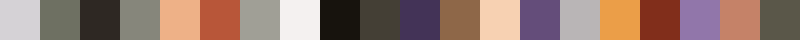

In [ ]:
colors = np.array([])
for i in range(20):
  new_color = np.repeat(colors_clustering_kmeans.cluster_centers_[i].reshape(1, -1), 1600, axis=0).reshape(40, 40, 3)
  if i == 0:
    colors = new_color
  else:
    colors = np.concatenate((colors, new_color), axis=1)
cv2_imshow(colors)

Получилось что-то адекватное. Приступим ко второй части. Тут уже просто - по обученному k-means определяем для каждго пикселя его кластер - для каждой картинки шлема считаем по сколько элементов каждого кластера в него входит и затем по этим векторам разделяем шлемы на два кластера.

In [ ]:
def second_team_kmeans(video_name, frame, num_of_colors=20):
  ''' Второй kmeans для классификации по командам '''
  # Берем инфоормацию о нужных фреймах
  frame_data = bboxes.loc[(bboxes['video'] == video_name) & (bboxes['frame'] == frame)]

  # Считаем картинку
  prefix_image_path = root + 'mp4_img/' + video_name[:-4] +  "/" + video_name[:-4] + '_'
  image_path = prefix_image_path + str(frame) + '.png'
  image = cv2.imread(image_path).T

  # Определим истинные таргеты
  teams = [label[0] == 'H' for label in frame_data['label']]
  nteams = [label[0] != 'H' for label in frame_data['label']]

  bbox_vectors = []
  for _, bbox in frame_data.iterrows():
     bbox_vectors.append(bbox_preprocessing(bbox, image, bbox_mask))

  # Разобьем на кластеры по цветам
  kmeans_vector = np.array(bbox_vectors).reshape(-1, 3)
  y_pred = colors_clustering_kmeans.predict(kmeans_vector)
  y_pred = y_pred.reshape(y_pred.shape[0]//np.sum(bbox_mask), np.sum(bbox_mask))

  # Получим нужное представление bbox
  add_clases = np.arange(num_of_colors)
  add_clases = np.repeat(add_clases.reshape(1, -1), y_pred.shape[0], axis=0)
  new_y_pred = np.concatenate((y_pred, add_clases), axis=1)
  counts = np.array( [np.unique(new_y_pred[i], axis=0, return_counts=True)[1] for i in range(new_y_pred.shape[0]) ])
  counts = counts - 1
  
  # Классифицируем на две команды
  kmeans_teams = KMeans(n_clusters=2)
  kmeans_teams.fit(counts)
  predicted_teams = kmeans_teams.predict(counts)

  return max(accuracy_score(teams, predicted_teams), accuracy_score(nteams, predicted_teams))

In [ ]:
def solution_accuracy(frame_accuracy, video_name):
  ''' Подсчет точности решений '''
  video_data = bboxes.loc[bboxes['video'] == video_name]
  frames = np.unique(video_data['frame'])
  sum_accuracy = 0
  cnt = 0
  for frame in tqdm(frames):
    try:
      fr_acc = frame_accuracy(video_name, frame)
      sum_accuracy += fr_acc
      cnt += 1
    except:
      continue
  return sum_accuracy/cnt

Применим это решение к нашим данным.

In [ ]:
result_first = pd.DataFrame()
for video in names:
    acc = solution_accuracy(second_team_kmeans, video)
    result_first = result_first.append({'Video': video, 'accuracy': np.round(acc, 3)}, ignore_index=True)
result_first

100%|██████████| 474/474 [03:21<00:00,  2.35it/s]


,Video,accuracy
0,57583_000082_Endzone.mp4,0.997
1,57583_000082_Sideline.mp4,0.993
2,57584_000336_Endzone.mp4,0.959
3,57584_000336_Sideline.mp4,0.976
4,57584_002674_Endzone.mp4,0.988
5,57584_002674_Sideline.mp4,0.981
6,57586_000540_Endzone.mp4,0.978
7,57586_000540_Sideline.mp4,0.994
8,57586_001934_Endzone.mp4,0.989
9,57586_001934_Sideline.mp4,0.991


**Вывод:** Как мы видим получилось очень хорошее качество 

**Второй метод**

С этим решением уже все сложнее, так как нам необходим все-таки трейн. 

Здесь мы обучаем нейроку, чтобы она хорошо преобразовывала картинку со шлемом в признаквое описание, так чтобы скалярное произведение полученных векторов после дальнейшего применения софтмакса, хорошо приближало матрицу смежности. Затем с помощью Агломеративной кластеризации разделим полученные векторы на два класса.  Напишем функции для этого решения.

In [ ]:
def team_assignment(distances):
    ''' Функция деления по командам с кластеризацией '''
    hier = AgglomerativeClustering(n_clusters=2)
    hier.fit(distances)
    predicted_teams = hier.labels_
    return predicted_teams

In [ ]:
class SecondSolutionModel(nn.Module):
  ''' Модель FeatureExtractor для второго решения '''
  def __init__(self, model):
    super(SecondSolutionModel, self).__init__()
    self.res = torch.nn.Sequential(*(list(model.children())[:-1]))

  def forward(self, video_name, frame, return_target, resize_shape=(60, 60)):
    ''' forward модели '''
    # Берем инфоормацию о нужных фреймах
    frame_data = bboxes.loc[(bboxes['video'] == video_name) & (bboxes['frame'] == frame)]

    # Считаем картинку
    prefix_image_path = root + 'mp4_img/' + video_name[:-4] +  "/" + video_name[:-4] + '_'
    image_path = prefix_image_path + str(frame) + '.png'
    image = cv2.imread(image_path).T

    predicted_vectors = []
    for _, bbox in frame_data.iterrows():
      # Обрежем картинку по bbox и сделаем resize
      left, right = bbox['left']- bbox['width'], bbox['left'] + 2*bbox['width']
      top, bottom = bbox['top']-bbox['height'], bbox['top'] + 2*bbox['height']
      hemlet_bbox = A.Resize(*resize_shape)(image = image[:, left : right, top : bottom].T)['image']
      # Сделаем Feature Extractor
      predicted_vectors.append(self.res(torch.FloatTensor(hemlet_bbox.T).unsqueeze(0).to(device)).squeeze(-1).squeeze(-1))

    matrix = torch.concatenate(predicted_vectors)
    predicted = matrix @ matrix.T

    if not return_target:
      return predicted

    # Истинная матрица смежности
    teams = [label[0] == 'H' for label in frame_data['label']]
    nteams = [label[0] != 'H' for label in frame_data['label']]
    target = torch.FloatTensor(np.array(teams).reshape(-1,1) == np.array(teams).reshape(1,-1)).to(device)

    return predicted, target, teams, nteams

In [ ]:
def train_loop(model, optimizer, loss_function, num_epochs, train_data, test_video_names, grad_acc_step = 4):
    ''' Цикл обучения '''
    cnt = 0
    for epoch in range(num_epochs):
        start_time = time.time()  
        # Обучение модели
        model.train(True)
        train_loss = []
        train_accuracy = []
        for idx in tqdm(train_data.index):
            try:
                video_name, frame = train_data.iloc[idx]
                logits, target, teams, nteams = model(video_name, frame, True)
                loss = loss_function(logits.view(-1), target.view(-1))
                loss.backward()
                cnt += 1
                if cnt == grad_acc_step:
                  optimizer.step()
                  optimizer.zero_grad()
                  cnt = 0
                train_loss.append(loss.cpu().data.numpy())
                # Подсчет точности на трейне
                predicted_teams = team_assignment(logits.detach().cpu().numpy())
                acc = max(accuracy_score(teams, predicted_teams), accuracy_score(nteams, predicted_teams))
                train_accuracy.append(acc)
            except:
                optimizer.zero_grad()
                continue

        # Подсчет точности на валидации(только на 20 первых фреймах)
        model.train(False)
        val_accuracy = []
        for video_name in tqdm(test_video_names):
            video_data = bboxes.loc[bboxes['video'] == video_name]
            frames = np.unique(video_data['frame'])
            for frame in frames:
                try:
                    logits, _, teams, nteams = model(video_name, frame, True)
                    predicted_teams = team_assignment(logits.detach().cpu().numpy())
                    acc = max(accuracy_score(teams, predicted_teams), accuracy_score(nteams, predicted_teams))
                    val_accuracy.append(acc)
                except:
                   continue
        # Вывод лосса и качества 
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss)))
        print("  training accuracy: \t\t\t{:.2f} %".format(
            np.mean(train_accuracy) * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy) * 100))

Теперь подготовим данные для обучения. В качестве обучения с трейновых видео возьмем не все фреймы, а только их часть.

In [ ]:
train_video_names = pd.DataFrame(names[:6])
test_video_names = names[-4:]
num_rows = 50
frames = pd.DataFrame(np.arange(0, 2 * num_rows, 2))
train_data = train_video_names.merge(frames, how='cross').iloc[np.random.permutation(6*num_rows)].reset_index()
train_data.drop(columns=['index'], inplace=True)

Обучим модель.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
back = resnet18(weights=tm.ResNet18_Weights.IMAGENET1K_V1)
model = SecondSolutionModel(back).to(device)
loss = torch.nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
train_loop(model, opt, loss, 10, train_data, test_video_names)

100%|██████████| 4/4 [00:14<00:00,  3.62s/it]


Epoch 1 of 10 took 95.205s
  training loss (in-iteration): 	24.639553
  training accuracy: 			64.38 %
  validation accuracy: 			81.91 %


100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


Epoch 2 of 10 took 91.976s
  training loss (in-iteration): 	0.693132
  training accuracy: 			61.82 %
  validation accuracy: 			74.79 %


100%|██████████| 4/4 [00:14<00:00,  3.51s/it]


Epoch 3 of 10 took 93.238s
  training loss (in-iteration): 	0.693028
  training accuracy: 			73.20 %
  validation accuracy: 			79.03 %


100%|██████████| 4/4 [00:14<00:00,  3.57s/it]


Epoch 4 of 10 took 91.268s
  training loss (in-iteration): 	0.634768
  training accuracy: 			90.89 %
  validation accuracy: 			74.57 %


100%|██████████| 4/4 [00:13<00:00,  3.50s/it]


Epoch 5 of 10 took 92.023s
  training loss (in-iteration): 	0.425099
  training accuracy: 			97.71 %
  validation accuracy: 			92.55 %


100%|██████████| 4/4 [00:13<00:00,  3.47s/it]


Epoch 6 of 10 took 91.493s
  training loss (in-iteration): 	0.376963
  training accuracy: 			99.18 %
  validation accuracy: 			92.10 %


100%|██████████| 4/4 [00:13<00:00,  3.49s/it]


Epoch 7 of 10 took 93.437s
  training loss (in-iteration): 	0.368513
  training accuracy: 			99.45 %
  validation accuracy: 			95.00 %


100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


Epoch 8 of 10 took 91.233s
  training loss (in-iteration): 	0.362178
  training accuracy: 			99.61 %
  validation accuracy: 			93.99 %


100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


Epoch 9 of 10 took 91.942s
  training loss (in-iteration): 	0.356728
  training accuracy: 			99.79 %
  validation accuracy: 			95.55 %


100%|██████████| 4/4 [00:14<00:00,  3.52s/it]

Epoch 10 of 10 took 91.213s
  training loss (in-iteration): 	0.364802
  training accuracy: 			99.56 %
  validation accuracy: 			95.26 %


In [ ]:
def frame_accuracy_second_solution(video_name, frame, resize_shape = (60, 60)):
  ''' Реализация второго метода решения '''
  model.eval()
  logits, _, teams, nteams = model(video_name, frame, True)
  predicted_teams = team_assignment(logits.detach().cpu().numpy())
  return max(accuracy_score(teams, predicted_teams), accuracy_score(nteams, predicted_teams))

Применим второе решение.

In [ ]:
result_first = pd.DataFrame()
for video in names:
    acc = solution_accuracy(frame_accuracy_second_solution, video)
    result_first = result_first.append({'Video': video, 'accuracy': np.round(acc, 3)}, ignore_index=True)
result_first

100%|██████████| 474/474 [12:32<00:00,  1.59s/it]


,Video,accuracy
0,57583_000082_Endzone.mp4,0.994
1,57583_000082_Sideline.mp4,0.966
2,57584_000336_Endzone.mp4,0.944
3,57584_000336_Sideline.mp4,0.917
4,57584_002674_Endzone.mp4,0.988
5,57584_002674_Sideline.mp4,0.964
6,57586_000540_Endzone.mp4,0.919
7,57586_000540_Sideline.mp4,0.879
8,57586_001934_Endzone.mp4,0.984
9,57586_001934_Sideline.mp4,0.909


**Вывод:** Как мы видим качество все так же не плохое.

Теперь сравним результаты.

In [8]:
result = pd.read_csv('result_3_big.csv')
print('Среднее на тесте на первом решении: ', result.first_accuracy[-4:].mean())
print('Среднее на тесте на втором решении: ', result.second_accuracy[-4:].mean())
result

Среднее на тесте на первом решении:  0.988
Среднее на тесте на втором решении:  0.92275


,Video,type,first_accuracy,second_accuracy
0,57583_000082_Endzone.mp4,train,0.997,0.994
1,57583_000082_Sideline.mp4,train,0.993,0.966
2,57584_000336_Endzone.mp4,train,0.959,0.944
3,57584_000336_Sideline.mp4,train,0.976,0.917
4,57584_002674_Endzone.mp4,train,0.988,0.988
5,57584_002674_Sideline.mp4,train,0.981,0.964
6,57586_000540_Endzone.mp4,test,0.978,0.919
7,57586_000540_Sideline.mp4,test,0.994,0.879
8,57586_001934_Endzone.mp4,test,0.989,0.984
9,57586_001934_Sideline.mp4,test,0.991,0.909


**Общий вывод:** Как мы видим на любом фрейме точность первого решения оказалось выше, чем у второго. Также преимущества первого решения заключаются в том, что здесь не нужно иметь предообученную модель, нужно просто иметь достаточо данных, также на таком количестве данных оно было намного быстрее. Тем не менее оба решения показали хороший результат.